In [1]:
#/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv
#/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv
#/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c4/img_16261.jpg



In [2]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance

In [3]:
tf.__version__

'2.5.0'

In [4]:
sample_path = ""
imgs_list_path = "data\driver_imgs_list.csv"
train_path = "data/imgs/train"

## 1.Check data distribution

In [5]:
driver_imgs_list = pd.read_csv(imgs_list_path)
driver_imgs_list.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [6]:
os.listdir(train_path)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [7]:
def pair_sort(className,values):
    for j in range(0,len(className)-1):
        for i in range(0,len(className)-1):
            if values[i] > values[i+1]:
                temp =  values[i+1]
                values[i+1] = values[i]
                values[i] = temp

                N_temp =  className[i+1]
                className[i+1] = className[i]
                className[i] = N_temp
    
    return className,values

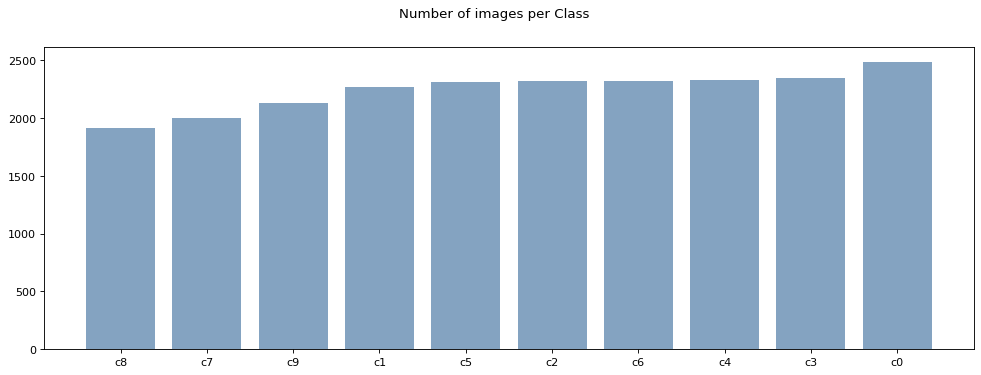

In [8]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

class_names = np.unique(driver_imgs_list['classname'])
class_image_list = [len(driver_imgs_list[driver_imgs_list['classname'] == current_class]) for current_class in class_names]

class_names,class_image_list=  pair_sort(class_names,class_image_list)

#plt.figure()
plt.suptitle('Number of images per Class')
plt.bar(class_names,class_image_list,color=(0.2, 0.4, 0.6, 0.6))
plt.show()

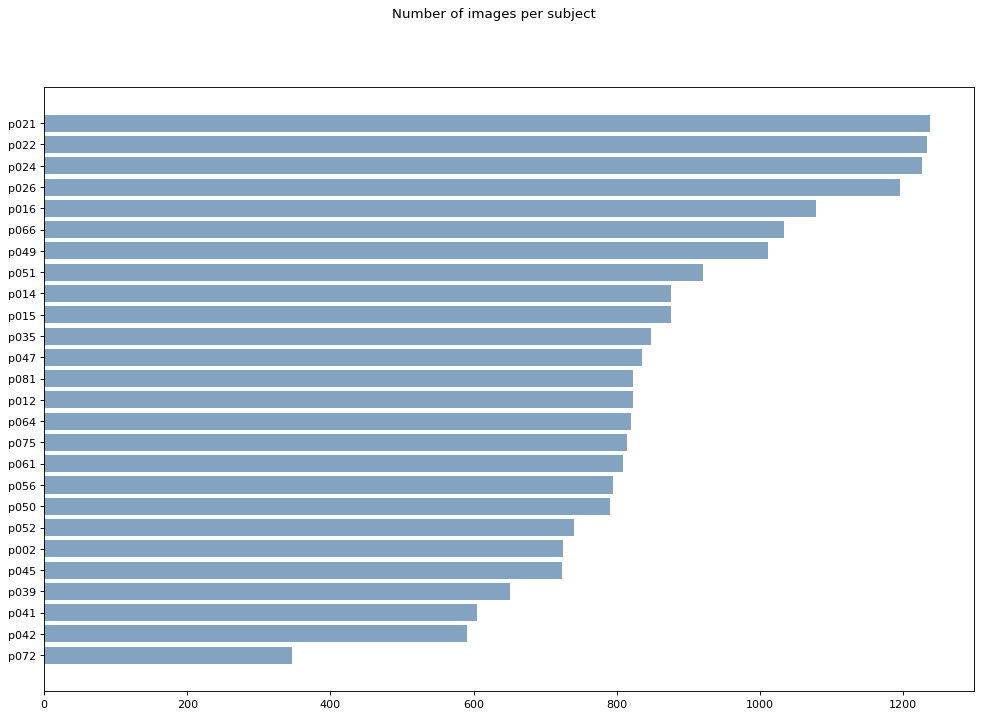

In [9]:
from matplotlib.pyplot import figure
sub_names = np.unique(driver_imgs_list['subject'])
sub_image_list = [len(driver_imgs_list[driver_imgs_list['subject'] == current_sub]) for current_sub in sub_names]
sub_names,sub_image_list=  pair_sort(sub_names,sub_image_list)

figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

y_pos = np.arange(len(sub_names))
# Create horizontal bars
plt.barh(y_pos, sub_image_list,color=(0.2, 0.4, 0.6, 0.6))
 
# Create names on the y-axis
plt.yticks(y_pos,sub_names )
plt.suptitle('Number of images per subject')

# Show graphic
plt.show()

In [10]:
img_width,img_height = (256,256)
model_input_shape = (img_width,img_height,3)
batch_size = 16
input_image = (img_width,img_height)

def load_image(path):
    read_path = train_path+"/"+path
    image = Image.open(read_path)
    image = image.resize(input_image)
    
    return np.asarray(image)

In [11]:
def show_images(image_ids,class_names):
    pixels = [load_image(path) for path in image_ids]
    
    num_of_images = len(image_ids)
    
    fig, axes = plt.subplots(
        1, 
        num_of_images, 
        figsize=(5 * num_of_images, 5 * num_of_images),
        
    )
   
    
    for i, image_pixels in enumerate(pixels):
        axes[i].imshow(image_pixels)
        axes[i].axis("off")
        axes[i].set_title(class_names[i])

## 2.Plot class images

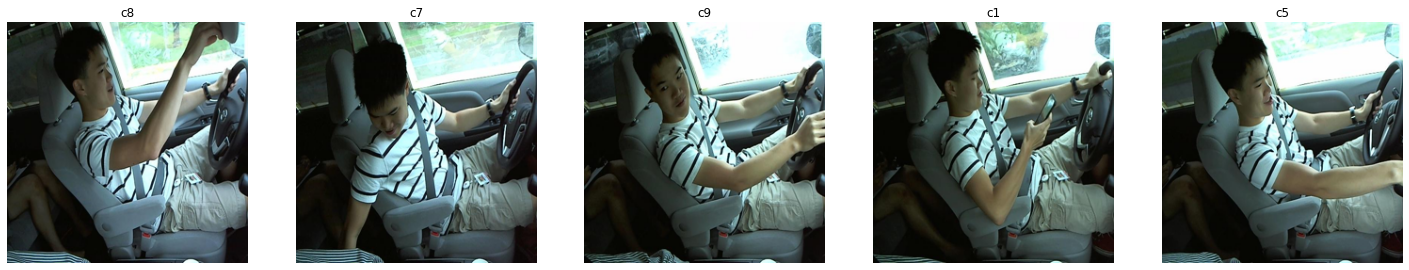

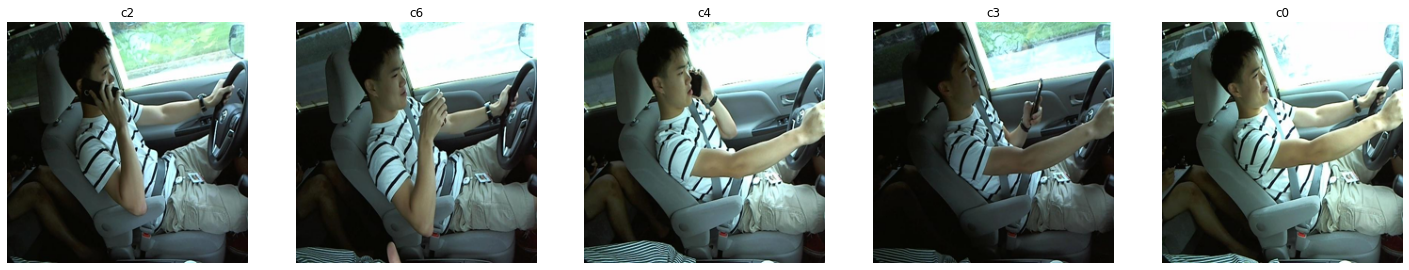

In [12]:
sub_names_imgs = [ current_class+"/"+driver_imgs_list[driver_imgs_list['classname'] == current_class]['img'].values[0] for current_class in class_names]

show_images(sub_names_imgs[:5],class_names[:5])
show_images(sub_names_imgs[5:],class_names[5:])

 ## 3. Split and load Train/Validation 

In [13]:
train_path = "data/imgs/train"
test_path = "data/imgs/test"

In [14]:
x_train = []
y_train = []

x_val = []
y_val = []


split_rate = 0.8
for current_class in class_names:
    select_df = driver_imgs_list[driver_imgs_list['classname'] == current_class ]
    image_list = select_df['img'].values
    train_amount = int(len(image_list)*split_rate)
    train_list = image_list[:train_amount]
    val_list = image_list[train_amount:]
    
    for filename in train_list:
        x_train.append(load_image(current_class+"/"+filename))
        y_train.append(current_class.replace('c',''))

    for filename in val_list:
        x_val.append(load_image(current_class+"/"+filename))
        y_val.append(current_class.replace('c',''))


## 4. Encode Labels

In [15]:
x_train = np.asarray(x_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
x_val = np.asarray(x_val)
y_val =tf.keras.utils.to_categorical(y_val, num_classes=10)
print("Train x Shape: ",x_train.shape)
print("Test x Shape: ",x_val.shape)


Train x Shape:  (17934, 256, 256, 3)
Test x Shape:  (4490, 256, 256, 3)


In [16]:
print("Train y Shape: ",y_train.shape)
print("Test y Shape: ",y_val.shape)

Train y Shape:  (17934, 10)
Test y Shape:  (4490, 10)


## 5. Create Model


In [17]:
base_model  = tf.keras.applications.resnet.ResNet50(include_top = False,
                                                  weights = 'imagenet',
                                                  input_shape = model_input_shape)
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [18]:
x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)

output =tf.keras.layers.Dense(units = len(class_names),activation = tf.nn.softmax)(x)
model = tf.keras.models.Model(inputs=base_model.inputs, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [19]:
num_epochs = 50
def lr_schedule(epoch,lr):
    # Learning Rate Schedule

    lr = lr
    total_epochs = num_epochs

    check_1 = int(total_epochs * 0.9)
    check_2 = int(total_epochs * 0.8)
    check_3 = int(total_epochs * 0.6)
    check_4 = int(total_epochs * 0.4)

    if epoch > check_1:
        lr *= 1e-4
    elif epoch > check_2:
        lr *= 1e-3
    elif epoch > check_3:
        lr *= 1e-2
    elif epoch > check_4:
        lr *= 1e-1

    print("[+] Current Lr rate : {} ".format(lr))
    return lr
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [20]:
history = model.fit(
      x = x_train,y=y_train,
      validation_data=(x_val,y_val),
      steps_per_epoch=16,
      batch_size = 8,
      epochs=num_epochs,
    
    callbacks = [lr_callback],
      verbose=1)

Epoch 1/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==============================] - 745s 48s/step - loss: 5.3750 - accuracy: 0.1875 - val_loss: 5.6247 - val_accuracy: 0.1318
Epoch 2/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==============================] - 707s 47s/step - loss: 2.9849 - accuracy: 0.4688 - val_loss: 5.1511 - val_accuracy: 0.2408
Epoch 3/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==============================] - 770s 51s/step - loss: 2.2337 - accuracy: 0.5859 - val_loss: 4.3701 - val_accuracy: 0.2445
Epoch 4/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==============================] - 770s 51s/step - loss: 1.4631 - accuracy: 0.7109 - val_loss: 5.2166 - val_accuracy: 0.3053
Epoch 5/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==============================] - 640s 42s/step - loss: 0.9834 - accuracy: 0.7812 - val_loss: 4.2871 - val_accuracy: 0.3196
Epoch 6/50
[+] Current Lr rate : 9.999999747378752e-05 
16/16 [==

## 6. Model Evaluation

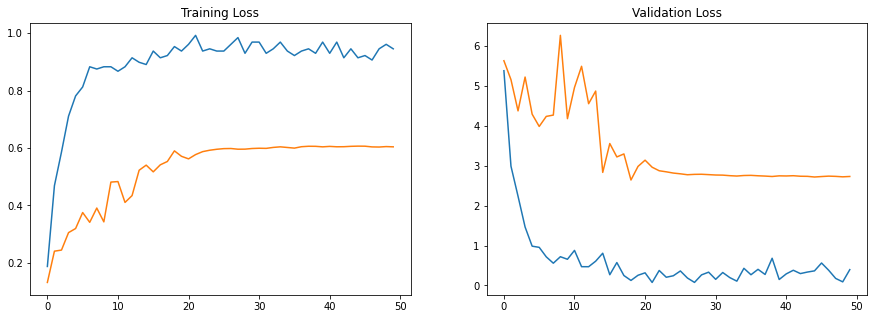

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])

In [28]:
import seaborn as sns
MODEL_PATH = os.path.join(os.getcwd(),"model","resnet")

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [26]:
def print_heatmap(matrix, class_names):
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [24]:
ypred = model.predict(x_val,verbose=1)

141/141 [==============================] - 487s 3s/step


In [25]:
from sklearn.metrics import confusion_matrix
class_names = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']

ypred_class = np.argmax(ypred,axis=1)
ytest = np.argmax(y_val,axis=1)

cm=confusion_matrix(ytest,ypred_class)
print(cm)

[[365   1   0  17   0   0   0  31   0  84]
 [ 40 357   2   0   0   0   6  10   3  36]
 [ 34   0 352   0   0   0   1  15  55   7]
 [ 79   7   0 367   0   0   0  11   2   4]
 [230   1 102  19   0   0   1  23  11  79]
 [ 88   0   0  42   0 312   0   4   0  17]
 [ 13  67  87   2   0   0 217  34  25  20]
 [ 43   1   4   2   0   0   0 343   6   2]
 [ 52   7  47   1   0   0   8  48 215   5]
 [133  15  12   2   0   0   1  71   8 184]]


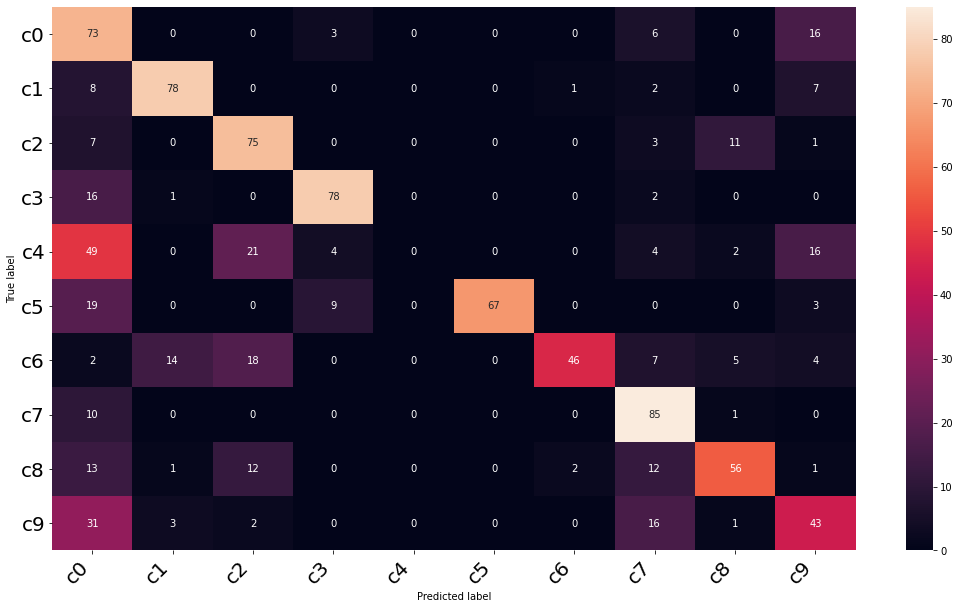

In [29]:
print_heatmap(cm,class_names)

In [31]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.604009
Precision: 0.609134
Recall: 0.604009
F1 score: 0.583436


C:\Users\SRIRAM\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
